# Train a 3D Convolutional Neural Network (3dCNN) to classify motor tasks

In [1]:
import os
import wandb
import torch
import pandas as pd
import numpy as np
import time
from delphi import mni_template
from glob import glob
from torch.utils.data import DataLoader
from torchinfo import summary

from delphi.networks.ConvNets import BrainStateClassifier3d
from delphi.utils.datasets import NiftiDataset
from delphi.utils.tools import ToTensor, compute_accuracy, convert_wandb_config, read_config
from sklearn.model_selection import StratifiedShuffleSplit

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def set_random_seed(seed):
    import random
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    g = torch.Generator()  # can be used in pytorch dataloaders for reproducible sample selection when shuffle=True
    g.manual_seed(seed)

    return g

g = set_random_seed(2020)

In [3]:
def wandb_plots(y_true, y_pred, y_prob, class_labels, dataset):
    wandb.log({
        f"{dataset}-ROC": wandb.plot.roc_curve(y_true=y_true, y_probas=y_prob, labels=class_labels),
        f"{dataset}-PR": wandb.plot.pr_curve(y_true=y_true, y_probas=y_prob, labels=class_labels, ),
        f"{dataset}-ConfMat": wandb.plot.confusion_matrix(y_true=y_true, preds=y_pred, class_names=class_labels)
    })

In [4]:
class_labels = sorted(["handleft", "handright", "footleft", "footright", "tongue"])

data_test = NiftiDataset("../t-maps/test", class_labels, 0, device=DEVICE, transform=ToTensor())

# we will split the train dataset into a train (80%) and validation (20%) set.
data_train_full = NiftiDataset("../t-maps/train", class_labels, 0, device=DEVICE, transform=ToTensor())

# we want one stratified shuffled split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2020)
idx_train, idx_valid = next(sss.split(data_train_full.data, data_train_full.labels))

data_train = torch.utils.data.Subset(data_train_full, idx_train)
data_valid = torch.utils.data.Subset(data_train_full, idx_valid)

In [7]:
model_cfg = {
    "channels": [1, 8, 16, 32, 64],
    "lin_neurons": [128, 64],
    "pooling_kernel": 2,
    "kernel_size": 7,
    "dropout": .5,
}
input_dims = (91, 109, 91)
model = BrainStateClassifier3d(input_dims, len(class_labels), model_cfg)
print(summary(model, (1,1,91,109,91)))
model.to(DEVICE);

Layer (type:depth-idx)                   Output Shape              Param #
BrainStateClassifier3d                   [100, 5]                  --
├─Dropout: 1-6                           [100, 128]                --
├─ReLU: 1-2                              --                        --
├─Softmax: 1-3                           --                        --
├─Sequential: 1-4                        --                        --
│    └─Sequential: 2-1                   [100, 8, 45, 54, 45]      --
│    │    └─Conv3d: 3-1                  [100, 8, 91, 109, 91]     2,752
│    │    └─ReLU: 3-2                    [100, 8, 91, 109, 91]     --
│    │    └─MaxPool3d: 3-3               [100, 8, 45, 54, 45]      --
│    └─Sequential: 2-2                   [100, 16, 22, 27, 22]     --
│    │    └─Conv3d: 3-4                  [100, 16, 45, 54, 45]     43,920
│    │    └─ReLU: 3-5                    [100, 16, 45, 54, 45]     --
│    │    └─MaxPool3d: 3-6               [100, 16, 22, 27, 22]     --
│    └─S

In [6]:
# set the wandb sweep config
# os.environ['WANDB_MODE'] = 'offline'
os.environ['WANDB_ENTITY'] = "philis893" # this is my wandb account name. This can also be a group name, for example
os.environ['WANDB_PROJECT'] = "thesis" # this is simply the project name where we want to store the sweep logs and plots

In [ ]:
hp = read_config("hyperparameter.yaml")

if os.path.exists(os.path.join(hp["name"], "state_dict.pth")):
    print("Already trained the network.")
else:
    with wandb.init(config=hp, name=hp["name"], group="first_steps") as run:

        save_name = run.config.name

        dl_test = DataLoader(data_test, batch_size=run.config.batch_size, shuffle=True, generator=g)
        dl_train = DataLoader(data_train, batch_size=run.config.batch_size, shuffle=True, generator=g)
        dl_valid = DataLoader(data_valid, batch_size=run.config.batch_size, shuffle=True, generator=g)

        best_loss, best_acc = 100, 0
        loss_acc = []
        train_stats, valid_stats = [], []
        # patience, patience_ctr = 9, 0

        # loop for the above set number of epochs
        for epoch in range(run.config.epochs):
            _, _ = model.fit(dl_train, lr=run.config.learning_rate, device=DEVICE)

            # for validating or testing set the network into evaluation mode such that layers like dropout are not active
            with torch.no_grad():
                tloss, tstats = model.fit(dl_train, device=DEVICE, train=False)
                vloss, vstats = model.fit(dl_valid, device=DEVICE, train=False)

            # the model.fit() method has 2 output parameters: loss, stats = model.fit()
            # the first parameter is simply the loss for each sample
            # the second parameter is a matrix of n_classes+2-by-n_samples
            # the first n_classes columns are the output probabilities of the model per class
            # the second to last column (i.e., [:, -2]) represents the real labels
            # the last column (i.e., [:, -1]) represents the predicted labels
            tacc = compute_accuracy(tstats[:, -2], tstats[:, -1])
            vacc = compute_accuracy(vstats[:, -2], vstats[:, -1])

            loss_acc.append(pd.DataFrame([[tloss, vloss, tacc, vacc]],
                                         columns=["train_loss", "valid_loss", "train_acc", "valid_acc"]))

            train_stats.append(pd.DataFrame(tstats.tolist(), columns=[*class_labels, *["real", "predicted"]]))
            train_stats[epoch]["epoch"] = epoch
            valid_stats.append(pd.DataFrame(vstats.tolist(), columns=[*class_labels, *["real", "predicted"]]))
            valid_stats[epoch]["epoch"] = epoch

            wandb.log({
                "train_acc": tacc, "train_loss": tloss,
                "valid_acc": vacc, "valid_loss": vloss
            })

            print('Epoch=%03d, train_loss=%2.3f, train_acc=%1.3f, valid_loss=%2.3f, valid_acc=%1.3f' % 
                 (epoch, tloss, tacc, vloss, vacc))

            if (vacc >= best_acc) and (vloss <= best_loss):
                # assign the new best values
                best_acc, best_loss = vacc, vloss
                wandb.run.summary["best_valid_accuracy"] = best_acc
                wandb.run.summary["best_valid_epoch"] = epoch
                # save the current best model
                model.save(save_name)
                # plot some graphs for the validation data
                wandb_plots(vstats[:, -2], vstats[:, -1], vstats[:, :-2], class_labels, "valid")

                # reset the patience counter
                #patience_ctr=0

            #else:
            #    patience_ctr+=1
            #
            #if patience_ctr > patience:
            #    print('Reached patience. Stopping training and continuing with test set.')
            #    break

        # save the files
        full_df = pd.concat(loss_acc)
        full_df.to_csv(os.path.join(save_name, "loss_acc_curves.csv"), index=False)
        full_df = pd.concat(train_stats)
        full_df.to_csv(os.path.join(save_name, "train_stats.csv"), index=False)
        full_df = pd.concat(valid_stats)
        full_df.to_csv(os.path.join(save_name, "valid_stats.csv"), index=False)

        # EVALUATE THE MODEL ON THE TEST DATA
        with torch.no_grad():
            testloss, teststats = model.fit(dl_test, train=False)
        testacc = compute_accuracy(teststats[:, -2], teststats[:, -1])
        wandb.run.summary["test_accuracy"] = testacc

        wandb.log({"test_accuraccy": testacc, "test_loss": testloss})
        wandb_plots(teststats[:, -2], teststats[:, -1], teststats[:, :-2], class_labels, "test")

        wandb.finish()

# Run the Layer-wise Relevance Propagation (LRP) algorithm

In [ ]:
def mask_voxels(data, prct_highest=.3):
    
    mask = 0
    
    return mask

In [ ]:
from zennit import composites
from delphi.utils.tools import save_in_mni

In [5]:
# load the trained network
model = BrainStateClassifier3d("motor-classifier")
model.eval()
model.to(torch.device("cpu"));

data_test = NiftiDataset("../t-maps/test", class_labels, 0, device=torch.device("cpu"), transform=ToTensor())
dl_test = DataLoader(data_test, batch_size=1, shuffle=False)

Loading from config file motor-classifier/config.yaml


In [ ]:
# Execute the LRP algorithm and save the resulting LRP maps somewhere.
shape = (1, 1, 91, 109, 91)

composite_kwargs = {
    'low': -1 * torch.ones(*shape, device=torch.device("cpu")),  # the lowest and ...
    'high': 1 * torch.ones(*shape, device=torch.device("cpu")),  # the highest pixel value for ZBox
}

attributor = composites.COMPOSITES['epsilon_gamma_box'](**composite_kwargs)

for param in model.parameters():
    param.requires_grad = False

out_dir_name = "motor-mapper-lrp"
if not os.path.exists(out_dir_name):
    os.mkdir(out_dir_name)
    
# create the composite context outside the main loop, such that the canonizers and hooks do not
# need to be registered and removed for each step.
with attributor.context(model) as modified_model:
    for j in range(len(class_labels)):
        dl = DataLoader(
            NiftiDataset('../t-maps/test', [class_labels[j]], 20, device=torch.device("cpu"), transform=ToTensor()),
            batch_size=20, shuffle=False, num_workers=0
        )
        
        print(f"Running LRP on {class_labels[j]}")
        
        for i, (volume, target) in enumerate(dl):
            data_norm = (volume.float())
            data_norm.requires_grad_()

            # one-hot encoding of the target labels
            output_relevance = torch.eye(model.config['n_classes'], device=torch.device("cpu"))[target]
            out = modified_model(data_norm)
            # a simple backward pass will accumulate the relevance in data_norm.grad
            torch.autograd.backward((out,), (output_relevance,))
            indi_lrp = np.moveaxis(data_norm.grad.squeeze().detach().numpy(), 0, -1)
            avg_lrp = indi_lrp.mean(axis=-1)

        save_in_mni(indi_lrp, os.path.join(out_dir_name, '%s.nii.gz' % class_labels[j]))
        save_in_mni(avg_lrp, os.path.join(out_dir_name, 'avg_%s.nii.gz' % class_labels[j]))
        

In [ ]:
# let us visualize the average LRP maps
# Brain_Data from the nltools toolbox allows us to visualize brain maps quit nicely
from nltools.data import Brain_Data

files = sorted(glob("motor-mapper-lrp/avg*.nii.gz"))
dat = Brain_Data(files)
dat.iplot(threshold="95%")

# Use different XAI algorithm

In [ ]:
# load the trained network
model = BrainStateClassifier3d("motor-classifier")
model.eval()
model.to(torch.device("cpu"));

In [ ]:
from zennit.attribution import Gradient, SmoothGrad

# Execute the LRP algorithm and save the resulting LRP maps somewhere.
shape = (1, 1, 91, 109, 91)

out_dir_name = "motor-mapper-smoothgrad"
if not os.path.exists(out_dir_name):
    os.mkdir(out_dir_name)
    
# create the composite context outside the main loop, such that the canonizers and hooks do not
# need to be registered and removed for each step.
with SmoothGrad(model=model, noise_level=.1, n_iter=20) as modified_model:
    for j in range(len(class_labels)):
        dl = DataLoader(
            NiftiDataset('../t-maps/test', [class_labels[j]], 20, device=torch.device("cpu"), transform=ToTensor()),
            batch_size=20, shuffle=False, num_workers=0
        )
        
        print(f"Running Gradient on {class_labels[j]}")
        
        for i, (volume, target) in enumerate(dl):
                
            # one-hot encoding of the target labels
            output_relevance = torch.eye(model.config['n_classes'], device=torch.device("cpu"))[target]
            out, attribution = modified_model(volume, output_relevance)
            # a simple backward pass will accumulate the relevance in data_norm.grad
            indi_lrp = np.moveaxis(attribution.squeeze().detach().numpy(), 0, -1)
            avg_lrp = indi_lrp.mean(axis=-1)

        save_in_mni(indi_lrp, os.path.join(out_dir_name, '%s.nii.gz' % class_labels[j]))
        save_in_mni(avg_lrp, os.path.join(out_dir_name, 'avg_%s.nii.gz' % class_labels[j]))

In [ ]:
files = sorted(glob("motor-mapper-smoothgrad/avg*.nii.gz"))
dat = Brain_Data(files)
dat.iplot(threshold="99%")

# TEST OCCLUSION

In [8]:
vol, target = data_test.__getitem__(0)

In [162]:
import nibabel as nib

brain_mask = nib.load(mni_template).get_fdata()
attribution = nib.load('motor-mapper-lrp/avg_handleft.nii.gz').get_fdata()
attribution_masked = np.multiply(attribution, brain_mask)
#below_zero = attribution<=0
#attribution[below_zero]=0

In [164]:
non_zero_vals = np.sum(attribution_masked!=0)
non_zero_vals

228483

In [191]:
attribution_flat = np.multiply(np.ones(attribution.shape), brain_mask).flatten()

occlusion_idx = np.argsort(a=attribution_masked.flatten())[:int(.2*non_zero_vals)]
attribution_flat[occlusion_idx] = 0

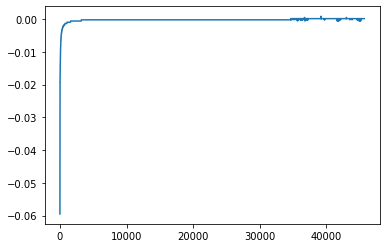

In [192]:
plt.plot(attribution.flatten()[occlusion_idx])

In [193]:
attribution_mask = np.reshape(attribution_flat, (1, 91, 109, 91))

In [194]:
test = np.multiply(vol, attribution_mask)

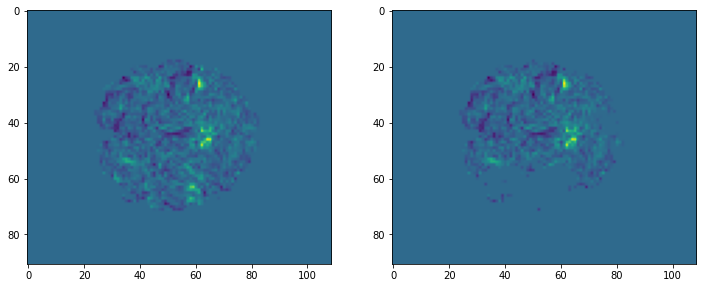

In [195]:
this_slice = 65
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(vol[0,:,:,this_slice])
axes[1].imshow(test[0,:,:,this_slice])

In [25]:
vol[:,occlusion_idx] = 0

ValueError: At least one stride in the given numpy array is negative, and tensors with negative strides are not currently supported. (You can probably work around this by making a copy of your array  with array.copy().) 